## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [11]:
from keras.layers import BatchNormalization, Activation

# 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = keras.layers.Activation('relu')(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

# 請於 BN 放在 Input Layer 後，並比較結果
def build_mlp3(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
BUILD_MLPS = ["type1", "type2", "type3"]

In [7]:
def mlp_compile(build_type="type1", Batch_Size=1024, results={}):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with batch size = %d" % (Batch_Size))

    if build_type == "type1":
        model = build_mlp(input_shape=x_train.shape[1:])
    elif build_type == "type2":
        model = build_mlp2(input_shape=x_train.shape[1:])
    elif build_type == "type3":
        model = build_mlp3(input_shape=x_train.shape[1:])

    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="sgd")

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=Batch_Size, 
              validation_data=(x_test, y_test), 
              shuffle=True)

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    exp_name_tag = "batchsize-{0}".format(Batch_Size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

def plotResult(results):
    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
    plt.title("Loss")
    plt.ylim([0, 5])
    plt.legend()
    plt.show()

    plt.figure(figsize=(8,6))
    for i, cond in enumerate(results.keys()):
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
    plt.title("Accuracy")
    plt.legend()
    plt.show()

## 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異

Experiment with batch size = 2
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_______________________________________

50000/50000 [==============================] - 430s 9ms/step - loss: 2.2451 - acc: 0.1571 - val_loss: 2.7383 - val_acc: 0.1994
Epoch 46/50
50000/50000 [==============================] - 375s 7ms/step - loss: 2.2418 - acc: 0.1618 - val_loss: 2.7274 - val_acc: 0.2347
Epoch 47/50
50000/50000 [==============================] - 376s 8ms/step - loss: 2.2419 - acc: 0.1616 - val_loss: 3.1637 - val_acc: 0.2214
Epoch 48/50
50000/50000 [==============================] - 377s 8ms/step - loss: 2.2459 - acc: 0.1602 - val_loss: 2.9568 - val_acc: 0.2190
Epoch 49/50
50000/50000 [==============================] - 378s 8ms/step - loss: 2.2474 - acc: 0.1608 - val_loss: 3.0761 - val_acc: 0.2082
Epoch 50/50
50000/50000 [==============================] - 379s 8ms/step - loss: 2.2459 - acc: 0.1621 - val_loss: 2.6798 - val_acc: 0.2091
Experiment with batch size = 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (Input

Epoch 44/50
50000/50000 [==============================] - 59s 1ms/step - loss: 1.1391 - acc: 0.5980 - val_loss: 1.4501 - val_acc: 0.4960
Epoch 45/50
50000/50000 [==============================] - 60s 1ms/step - loss: 1.1366 - acc: 0.5955 - val_loss: 1.3774 - val_acc: 0.5224
Epoch 46/50
50000/50000 [==============================] - 59s 1ms/step - loss: 1.1385 - acc: 0.5950 - val_loss: 1.3468 - val_acc: 0.5324
Epoch 47/50
50000/50000 [==============================] - 59s 1ms/step - loss: 1.1254 - acc: 0.6005 - val_loss: 1.3859 - val_acc: 0.5214
Epoch 48/50
50000/50000 [==============================] - 57s 1ms/step - loss: 1.1217 - acc: 0.6036 - val_loss: 1.4078 - val_acc: 0.5118
Epoch 49/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.1238 - acc: 0.5999 - val_loss: 1.3334 - val_acc: 0.5363
Epoch 50/50
50000/50000 [==============================] - 58s 1ms/step - loss: 1.1182 - acc: 0.6030 - val_loss: 1.3507 - val_acc: 0.5269
Experiment with batch size = 32
__

50000/50000 [==============================] - 32s 641us/step - loss: 0.9148 - acc: 0.6748 - val_loss: 1.5502 - val_acc: 0.4945
Epoch 43/50
50000/50000 [==============================] - 32s 646us/step - loss: 0.9076 - acc: 0.6772 - val_loss: 1.5032 - val_acc: 0.5032
Epoch 44/50
50000/50000 [==============================] - 31s 613us/step - loss: 0.8921 - acc: 0.6808 - val_loss: 1.6386 - val_acc: 0.4719
Epoch 45/50
50000/50000 [==============================] - 33s 657us/step - loss: 0.9092 - acc: 0.6762 - val_loss: 1.5914 - val_acc: 0.4899
Epoch 46/50
50000/50000 [==============================] - 32s 633us/step - loss: 0.9183 - acc: 0.6733 - val_loss: 1.5073 - val_acc: 0.5063
Epoch 47/50
50000/50000 [==============================] - 31s 619us/step - loss: 0.9172 - acc: 0.6748 - val_loss: 1.4709 - val_acc: 0.5117
Epoch 48/50
50000/50000 [==============================] - 33s 668us/step - loss: 0.8990 - acc: 0.6822 - val_loss: 1.5190 - val_acc: 0.5035
Epoch 49/50
50000/50000 [=======

50000/50000 [==============================] - 14s 283us/step - loss: 0.4882 - acc: 0.8376 - val_loss: 2.0499 - val_acc: 0.4673
Epoch 41/50
50000/50000 [==============================] - 15s 310us/step - loss: 0.4709 - acc: 0.8410 - val_loss: 2.1017 - val_acc: 0.4411
Epoch 42/50
50000/50000 [==============================] - 15s 294us/step - loss: 0.4658 - acc: 0.8432 - val_loss: 2.4769 - val_acc: 0.3948
Epoch 43/50
50000/50000 [==============================] - 14s 274us/step - loss: 0.4654 - acc: 0.8416 - val_loss: 2.1668 - val_acc: 0.4247
Epoch 44/50
50000/50000 [==============================] - 15s 295us/step - loss: 0.4347 - acc: 0.8531 - val_loss: 2.2885 - val_acc: 0.4191
Epoch 45/50
50000/50000 [==============================] - 15s 302us/step - loss: 0.4281 - acc: 0.8558 - val_loss: 2.1644 - val_acc: 0.4483
Epoch 46/50
50000/50000 [==============================] - 14s 272us/step - loss: 0.4228 - acc: 0.8577 - val_loss: 2.3028 - val_acc: 0.4294
Epoch 47/50
50000/50000 [=======

50000/50000 [==============================] - 10s 208us/step - loss: 0.5423 - acc: 0.8277 - val_loss: 1.9659 - val_acc: 0.4399
Epoch 39/50
50000/50000 [==============================] - 9s 185us/step - loss: 0.5239 - acc: 0.8338 - val_loss: 1.9911 - val_acc: 0.4336
Epoch 40/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.5067 - acc: 0.8398 - val_loss: 1.9426 - val_acc: 0.4509
Epoch 41/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.4888 - acc: 0.8474 - val_loss: 2.1916 - val_acc: 0.4352
Epoch 42/50
50000/50000 [==============================] - 10s 209us/step - loss: 0.4732 - acc: 0.8527 - val_loss: 2.4645 - val_acc: 0.3953
Epoch 43/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.4559 - acc: 0.8593 - val_loss: 2.2696 - val_acc: 0.4062
Epoch 44/50
50000/50000 [==============================] - 9s 186us/step - loss: 0.4466 - acc: 0.8619 - val_loss: 2.0985 - val_acc: 0.4447
Epoch 45/50
50000/50000 [==========

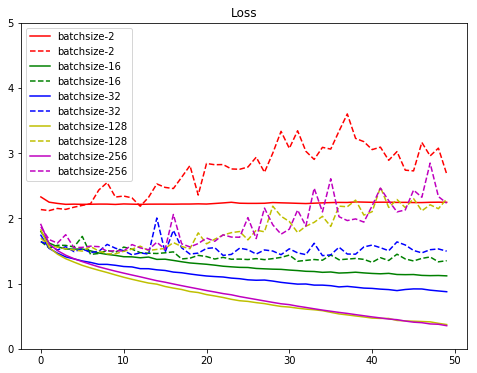

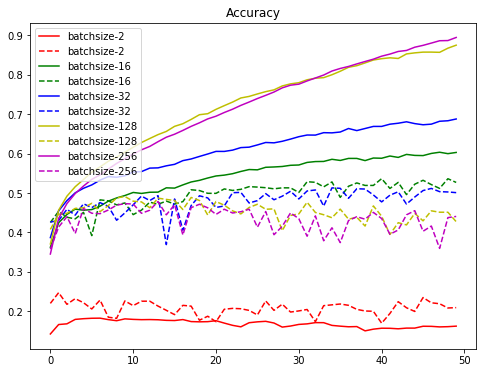

In [9]:
results = {}
for batch_size in BATCH_SIZE:
    mlp_compile(Batch_Size=batch_size, results=results)

plotResult(results)

## 請嘗試將 BN 放在 Activation 之前，並比較訓練結果

Experiment with batch size = 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)  

50000/50000 [==============================] - 6s 128us/step - loss: 0.8616 - acc: 0.7254 - val_loss: 1.6559 - val_acc: 0.4488
Epoch 47/50
50000/50000 [==============================] - 7s 131us/step - loss: 0.8499 - acc: 0.7294 - val_loss: 1.6628 - val_acc: 0.4491
Epoch 48/50
50000/50000 [==============================] - 7s 140us/step - loss: 0.8329 - acc: 0.7362 - val_loss: 1.6720 - val_acc: 0.4522
Epoch 49/50
50000/50000 [==============================] - 7s 143us/step - loss: 0.8172 - acc: 0.7425 - val_loss: 1.7022 - val_acc: 0.4450
Epoch 50/50
50000/50000 [==============================] - 7s 139us/step - loss: 0.8050 - acc: 0.7483 - val_loss: 1.6763 - val_acc: 0.4476


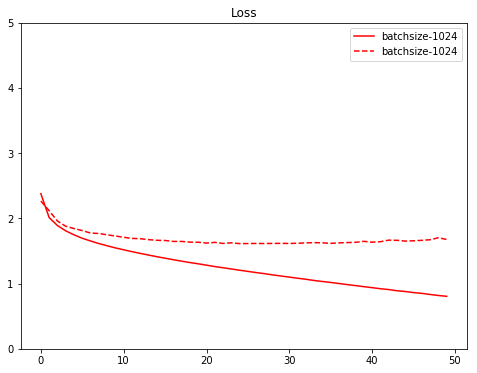

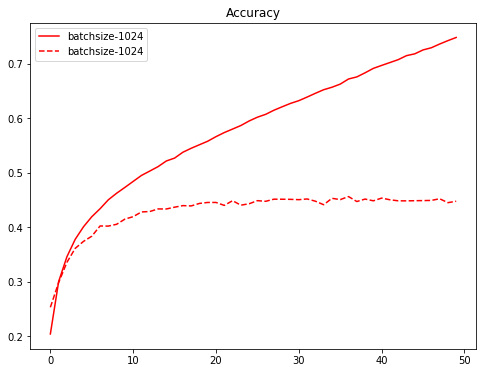

In [12]:
results = {}
mlp_compile(build_type="type2", results=results)
plotResult(results)

## 請於 BN 放在 Input Layer 後，並比較結果

Experiment with batch size = 1024
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [========================

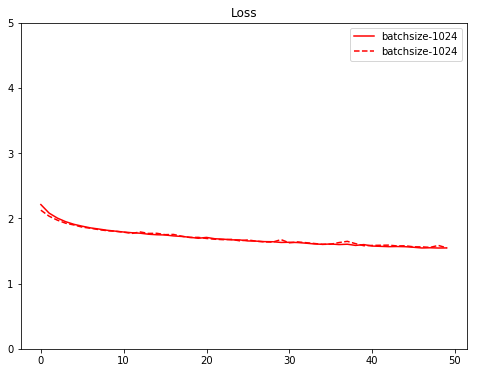

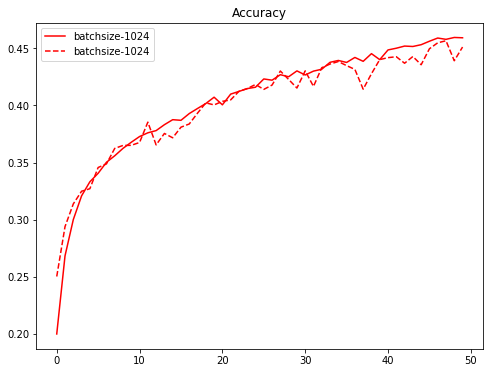

In [13]:
results = {}
mlp_compile(build_type="type3", results=results)
plotResult(results)